# Take Home Exam -- Thanks COVID-19

In [1]:
#!jupyter nbconvert --to python exam.ipynb
#!PATH="$PATH:/Library/TeX/texbin" jupyter nbconvert --to pdf exam.ipynb

In [2]:
import numpy as np
import scipy.spatial
import scipy as spy
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import *

In [3]:
# %matplotlib inline
# mpl.rcParams["figure.dpi"]= 250
%matplotlib widget 

## NURBS Surface 
$P(u, v) = \frac{ \sum_{i = 0}^{1} \sum_{j = 0}^{2} h_{i,j} * P_{i, j} * N_{i, 2}(u) * N_{j, 3}(v) }{ \sum_{i = 0}^{1} \sum_{j = 0}^{2} h_{i, j} * N_{i, 2}(u) * N_{j, 3}(v) }$

### Plot the NURBS Surface

In [4]:
def nurbs_func(p: Sequence[Sequence[Sequence[float]]], hSubI: Sequence[float], hSubJ: Sequence[float], u: float, v: float):
    """Summation series for each i, j for a given u, v input."""
 
    def h_sub_i_sub_j(hSubI: Sequence[float], hSubJ: Sequence[float], i: int, j: int) -> int:
        """Weighting factors for a given i, j."""
        return hSubI[i]*hSubJ[j]

    def n_sub_i_sub_2(i: int, u: float) -> float:
        """Basis function along u direction."""
        if i == 0:
            return (1-u if u >= 0 and u <= 1 else 0)
        elif i == 1:
            return (u if u >= 0 and u <= 1 else 0)
        else:
            raise IndexError(f"i = {i} is not within the bounds of this basis function")

    def n_sub_j_sub_3(j: int, v: float) -> float:
        """Basis function along v direction."""
        if j == 0:
            return ((1-v)**2 if v >= 0 and v <= 1 else 0)
        elif j == 1:
            return (2*v*(1-v) if v >= 0 and v <= 1 else 0) 
        elif j == 2:
            return (v**2 if v >= 0 and v <= 1 else 0)
        else:
            raise IndexError(f"i = {i} is not within the bounds of this basis function")
    
    num, den = 0, 0
    for i in range(2):
        for j in range(3):
            num += h_sub_i_sub_j(hSubI, hSubJ, i, j)*p[i, j]*n_sub_i_sub_2(i, u)*n_sub_j_sub_3(j, v)
            den += h_sub_i_sub_j(hSubI, hSubJ, i, j)*n_sub_i_sub_2(i, u)*n_sub_j_sub_3(j, v)
    return num / den

p = np.array([ # control points
    [[10, 0, 0], [10, 10, 0], [0, 10, 0]],
    [[10, 0, 50], [10, 10, 50], [0, 10, 50]],
])

hSubI = np.array([1, 2, 1])
hSubJ = np.array([1, 2, 1])

start = 0
stop = 1
step = .01
u = np.arange(start, stop + step, step)
v = u.copy()

pOut = np.zeros((len(u), len(v), 3))
for iu, uu in enumerate(u):
    for iv, vv in enumerate(v):
        pOut[iu, iv] = nurbs_func(p, hSubI, hSubJ, uu, vv)
 
# plot surface
fig = plt.figure(1)
ax = plt.axes(projection="3d")
ax.plot_surface(pOut[:, :, 0], pOut[:, :, 1], pOut[:, :, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(-30, 0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## VTA Chordal Error

### Plot the STL facet

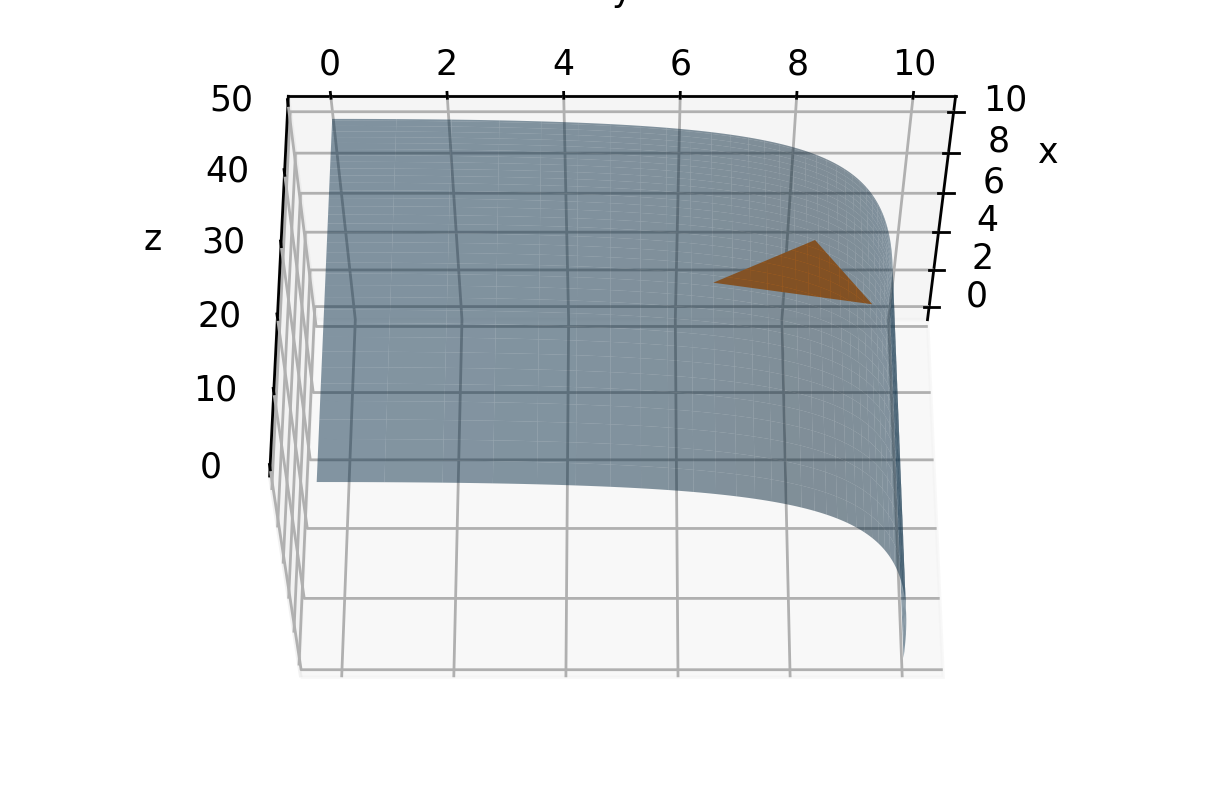

In [4]:
vertsSubUV = np.array([
    [0.4, 0.3],
    [0.6, 0.5],
    [0.5, 0.7],
])
vertsSubXYZ = np.array([ # vertexes on STL facet
    nurbs_func(p, hSubI, hSubJ, *vertsSubUV[0, :]),
    nurbs_func(p, hSubI, hSubJ, *vertsSubUV[1, :]),
    nurbs_func(p, hSubI, hSubJ, *vertsSubUV[2, :]),
])

fig = plt.figure(2)
ax = plt.axes(projection="3d")
ax.plot_surface(pOut[:, :, 0], pOut[:, :, 1], pOut[:, :, 2], alpha=0.5)
ax.plot_trisurf(vertsSubXYZ[:, 0], vertsSubXYZ[:, 1], vertsSubXYZ[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(-30, 0)
plt.show()

### Generate $r$
* In $U$, $V$ space:
    * $a$, $b$, $c$ correspond to 3 vertices of the facet 
    * $ab$ and $bc$ are points along the line from $a \rightarrow b$ and $b \rightarrow c$, respectively
    * $r$ contains the mesh of points between $ab$ and $bc$

In [5]:
a = vertsSubUV[0, :]
b = vertsSubUV[1, :]
c = vertsSubUV[2, :]
step = .01
t = np.arange(0, 1+step, step)
ab = np.array([a + tt * (b - a) for tt in t]) 
ac = np.array([a + tt * (c - a) for tt in t]) 

s = t.copy()
r = np.zeros((len(t), len(s), 2))
for i, tt in enumerate(t):
    for j, ss in enumerate(s):
        r[i, j, :] = ab[i, :] + ss * (ac[i, :] - ab[i, :])

# sanity check
assert np.all(r[0, 0, :] == ab[0, :]) # start of AB
assert np.all(r[-1, 0, :] == ab[-1, :]) # end of AB
assert np.all(r[0, -1, :] == ac[0, :]) # start of BC
assert np.all(r[-1, -1, :] == ac[-1, :]) # end of BC

### Generate $p_{CAD}$
* In $X$, $Y$, $Z$ space:
    * $p_{CAD}$ is the analogous NURBS points corresponding to $r$ (which is U, V space)
    * $a$, $b$, $c$ correspond to 3 vertices of the facet 
    * $n$ and $u$ are the the normal and unit normal vectors, respectively

In [6]:
pSubCAD = np.zeros((r.shape[0], r.shape[1], 3))
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        pSubCAD[i, j, :] = nurbs_func(p, hSubI, hSubJ, *r[i, j, :])

a = vertsSubXYZ[0, :]
b = vertsSubXYZ[1, :]
c = vertsSubXYZ[2, :]
n = np.cross(b-a, c-a) # ab x ac
u = n / np.linalg.norm(n)

### Generate $P_{STL}$
* Find intersection on STL facet of line extending from $P_{CAD}$ parallel to unit normal, $u$ of STL facet
    * We cannot assume that points on $P_{CAD}$ projects on $P_{STL}$ are inside the triangle; we must do inside poly test
    * [Intersection of line and plane](https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection) (tried multiple methods; only method I could get to work)

In [7]:
def intersect_line_plane( \
                         pointOnPlane: Sequence[float], \
                         pointOnLine: Sequence[float], \
                         normalToPlane: Sequence[float], \
                         directionOfLine: Sequence[float] \
                        ) -> Sequence[float]:
    """Find intersection point between line and plane (assuming there is one)."""
    u = normalToPlane / np.linalg.norm(normalToPlane)
    _lambda = np.dot(pointOnPlane - pointOnLine, normalToPlane) / np.dot(normalToPlane, normalToPlane)
    intersectionPoint = pointOnLine + _lambda * u
    return intersectionPoint
    

areaSubABC = 0.5 * np.dot(n, np.cross(b-a, c-a))
pSubSTL = np.zeros((r.shape[0], r.shape[1], 3))
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        d = intersect_line_plane(vertsSubXYZ[0, :], pSubCAD[i, j, :], n, n)
        # _lambda = np.dot(V[0, :] - PSubCAD[i, j, :], n) / np.dot(n, n)
        # D = PSubCAD[i, j, :] + _lambda * u
                
        areaSubABD = 0.5 * np.dot(n, np.cross(b-a, d-a)) # ab x ad 
        areaSubBCD = 0.5 * np.dot(n, np.cross(c-b, d-b)) # bc x bd
        areaSubADC = 0.5 * np.dot(n, np.cross(d-a, c-a)) # ad x ac
        if np.isclose( areaSubABC, np.sum([areaSubABD, areaSubBCD, areaSubADC]) ):
            pSubSTL[i, j, :] = d
        else:
            pSubSTL[i, j, :] = np.zeros((1, 3))

### Find Error between $P_{CAD}$ and $P_{STL}$ via Euclidean Distance

In [8]:
errCh = np.zeros((r.shape[0], r.shape[1]))
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        if np.all( pSubSTL[i, j, :] != np.zeros((1, 3)) ):
            errCh[i, j] = spy.spatial.distance.euclidean(pSubSTL[i, j, :], pSubCAD[i, j, :])
            
errChSubMaxLoc = np.unravel_index(np.argmax(errCh), errCh.shape)
errChSubMax = errCh[errChSubMaxLoc]
pSubSTLSubMax = pSubSTL[errChSubMaxLoc]
pSubCADSubMax = pSubCAD[errChSubMaxLoc]
print(f"The location of the maximum chordal error (on the NURBs Surface) is {pSubCADSubMax}\nThe maximum chordal error is {errChSubMax}.")

The location of the maximum chordal error (on the NURBs Surface) is [ 8.35985834  8.30652387 30.98688751]
The maximum chordal error is 0.01979204726424013.


## VTA Chordal Error Minimization by Increasing STL Facet Density

### Generate the Coordinatees and Normals of the New Facets

In [9]:
vertsSubUV = np.append(vertsSubUV, [r[errChSubMaxLoc]+1e-25,], axis=0) # plt.plot_trisurf requires xArr, yArr, and zArr to each to unique
vertsSubXYZ = np.append(vertsSubXYZ, [nurbs_func(p, hSubI, hSubJ, *vertsSubUV[3, :]),], axis=0)
faces = np.array([
    [0, 1, 3], [1, 2, 3], [2, 0, 3]
])
for i, ff in enumerate(faces):
    vv = vertsSubXYZ[ff, :]
    a = vv[0, :]
    b = vv[1, :]
    c = vv[2, :]
    u = - np.cross(b-a, c-a)
    print(f"Face {i} vertices in\nU,V space:\n{vertsSubUV[ff, :]}\nX, Y, Z space:\n{vv}\nwith unit normal:\n{u}\n")

Face 0 vertices in
U,V space:
[[0.4   0.3  ]
 [0.6   0.5  ]
 [0.449 0.496]]
X, Y, Z space:
[[ 9.36619718  6.54929577 28.57142857]
 [ 8.33333333  8.33333333 37.5       ]
 [ 8.35985834  8.30652387 30.98688751]]
with unit normal:
[11.38026712  6.49032799  0.01963109]

Face 1 vertices in
U,V space:
[[0.6   0.5  ]
 [0.5   0.7  ]
 [0.449 0.496]]
X, Y, Z space:
[[ 8.33333333  8.33333333 37.5       ]
 [ 6.54929577  9.36619718 33.33333333]
 [ 8.35985834  8.30652387 30.98688751]]
with unit normal:
[ 6.83886453 11.73015818 -0.02043236]

Face 2 vertices in
U,V space:
[[0.5   0.7  ]
 [0.4   0.3  ]
 [0.449 0.496]]
X, Y, Z space:
[[ 6.54929577  9.36619718 33.33333333]
 [ 9.36619718  6.54929577 28.57142857]
 [ 8.35985834  8.30652387 30.98688751]]
with unit normal:
[-1.56364316  2.01201997 -2.11518101]



### Plot the New STL Facets

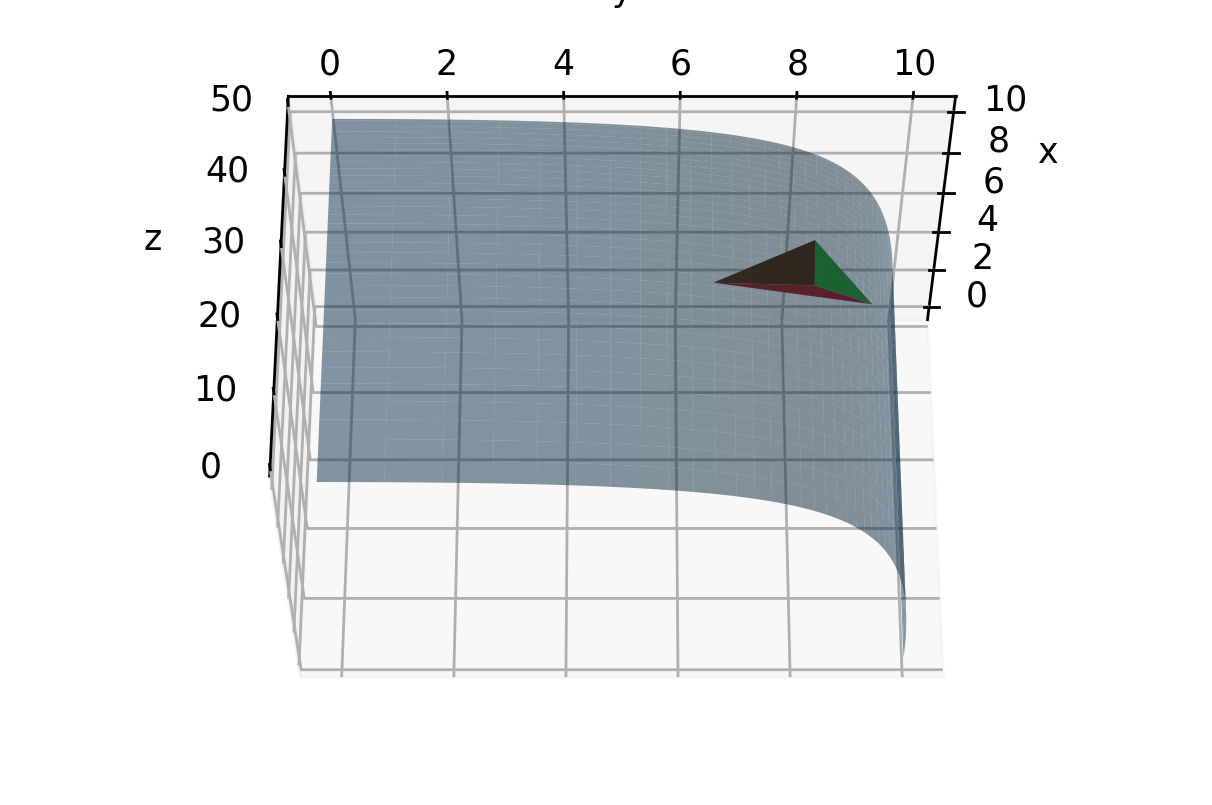

In [10]:
fig = plt.figure(5)
ax = plt.axes(projection="3d")
ax.plot_surface(pOut[:, :, 0], pOut[:, :, 1], pOut[:, :, 2], alpha=0.5)
for ff in faces:
    vv = vertsSubXYZ[ff, :]
    ax.plot_trisurf(vv[:, 0], vv[:, 1], vv[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(-30, 0)
plt.show()

### Calculate the Chordal Error of Each STL Facet

In [11]:
for i, ff in enumerate(faces):
    vvUV = vertsSubUV[ff, :]
    centUV = np.mean(vvUV, axis=0)
    centXYZSubCAD = nurbs_func(p, hSubI, hSubJ, *centUV)
    
    vvXYZ = vertsSubXYZ[ff, :]
    a, b, c = [vvXYZ[j, :] for j in range(3)]
    n = np.cross(b-a, c-a) # ab x ac 
    u = n / np.linalg.norm(n)
    areaSubABC = 0.5 * np.dot(n, np.cross(b-a, c-a))

    _lambda = np.dot(vvXYZ[0, :] - centXYZSubCAD, n) / np.dot(n, n)
    d = centXYZSubCAD + _lambda * u
   
    # skip the inside poly test since its the centroid
    centXYZSubSTL = d
    errCh = spy.spatial.distance.euclidean(centXYZSubSTL, centXYZSubCAD)
    print(f"Face {i} centroid chordal error: {errCh}")
   

Face 0 centroid chordal error: 0.008125650751133874
Face 1 centroid chordal error: 0.008160420798443757
Face 2 centroid chordal error: 0.0003195429397797934
